In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time

In [2]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')

In [3]:
from scripts.core import TN_utils, models, compiling, optimizers
reload(TN_utils)

Using gpu device 1: Tesla M2070 (CNMeM is disabled, CuDNN not available)


<module 'scripts.core.TN_utils' from '/home/matsui-k/projects/d-rcn/scripts/core/TN_utils.pyc'>

In [4]:
fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=1, i_indiv=0, mask_thresh=0.5)

(430080, 43, 10) (430080, 10) (430080,)


In [5]:
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(fe_vec, gt_vec, mask_vec)

(21485, 10, 43)
(21485, 10)
(5372, 10, 43)
(5372, 10)


In [11]:
rcn_2layer = models.Rcn2layer_wo_bn(
    n_tensors_list=[fe_vec.shape[1], 1024],
    func_key_list=["relu", "linear"],
    l2_reg=0.,
    gamma_scale=10**-2,
    drop_list=[0.9, 1.],
    bias_scale=0.)
                            
result = compiling.compile_bn(
    data_set=data_set,
    model=rcn_2layer,
    make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, s_input, s_target, s_test_input, s_test_target, param_list= result

batch_size = 1024
N = s_input.get_value(borrow=True).shape[0]
batch_size = batch_size
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = data_set[2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 501
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.99
        print i_epoch, training_error, test_error
print time.clock() - start_time

0.0467252098024 0.0420729704201
0.0351410880685 0.0303439088166
0.0304527375847 0.028105629608
0.0260666552931 0.0238355007023
0.0255585610867 0.0238751601428
0.0239480081946 0.0229888428003
0.0237129330635 0.0222719330341
0.0247577726841 0.0209714602679
0.0218723230064 0.019804764539
0.0228291805834 0.0184831917286
0.0209274813533 0.0192262586206
0.0202941149473 0.0178962051868
0.0214603040367 0.0180080067366
0.0211820360273 0.0178387518972
0.0195111241192 0.0177319478244
0.0214704480022 0.0166245307773
0.019751906395 0.0174483843148
0.0186514239758 0.0169522222131
0.0189744476229 0.0173564963043
0.01932868734 0.0165398567915
0.0182805713266 0.0157987978309
0.0180568099022 0.0161172803491
0.0171922314912 0.0160091537982
0.0191243030131 0.016285136342
0.0172367878258 0.0157320089638
0.0183648150414 0.016474140808
0.0182041358203 0.0161778982729
0.0167847108096 0.0163521654904
0.0167417731136 0.0151411788538
0.0173451956362 0.0163927655667
0.0169227588922 0.0154519602656
0.0173632800579

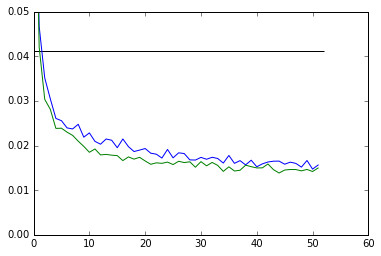

In [12]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.05)
plt.hlines(0.0411, 0, training_error_array.shape[0])

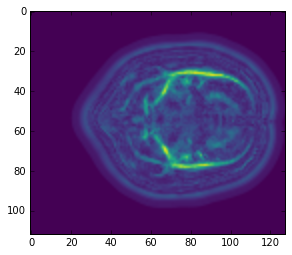

In [13]:
pred_train = TN_utils.predict_original_feature(f_output, fe_vec, norm_coef)
pred_train_vol = pred_train.reshape(vol_shape+(pred_train.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_train_vol, axis=0)[:, :, 15])

(430080, 43, 10)


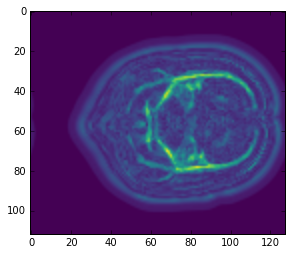

In [14]:
fe_test = TN_utils.load_hardi(i_order=1, i_indiv=1, only_feature=True)
pred_test = TN_utils.predict_original_feature(f_output, fe_test, norm_coef)
pred_test_vol = pred_test.reshape(vol_shape+(pred_test.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_test_vol, axis=0)[:, :, 15])

In [15]:
sio.savemat('../../../results/hardi_in_ex/Jun7_dropout/a2_all_train_1506.mat', {'pred' : pred_train_vol}) 
sio.savemat('../../../results/hardi_in_ex/Jun7_dropout/a2_all_test_1507.mat', {'pred' : pred_test_vol})